In [1]:
%run 0-utils/0-Base.ipynb

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
%%time

# schema = StructType([
#     StructField("authorized_flag",      ShortType(),     nullable=False),
#     StructField("card_id",              StringType(),    nullable=False),
#     StructField("city_id",              ShortType(),     nullable=False),
#     StructField("category_1",           ShortType(),     nullable=False),
#     StructField("installments",         ShortType(),     nullable=False),
#     StructField("category_3",           StringType(),    nullable=True),
#     StructField("merchant_category_id", ShortType(),     nullable=False),
#     StructField("merchant_id",          StringType(),    nullable=True),
#     StructField("month_lag",            ShortType(),     nullable=False),
#     StructField("purchase_amount",      FloatType(),     nullable=False),
#     StructField("purchase_date",        TimestampType(), nullable=False),
#     StructField("category_2",           FloatType(),     nullable=True),
#     StructField("state_id",             ShortType(),     nullable=False),
#     StructField("subsector_id",         ShortType(),     nullable=False),
# ])

transactions_dfs = dict(old=spark.read.csv("data/raw/old_transactions.csv", header=True),
                        new=spark.read.csv("data/raw/new_transactions.csv", header=True))

CPU times: user 3.12 ms, sys: 651 µs, total: 3.77 ms
Wall time: 2.45 s


OLD
+------------------+------------------+
|min(purchase_date)|max(purchase_date)|
+------------------+------------------+
|        2017-01-06|        2018-01-31|
+------------------+------------------+



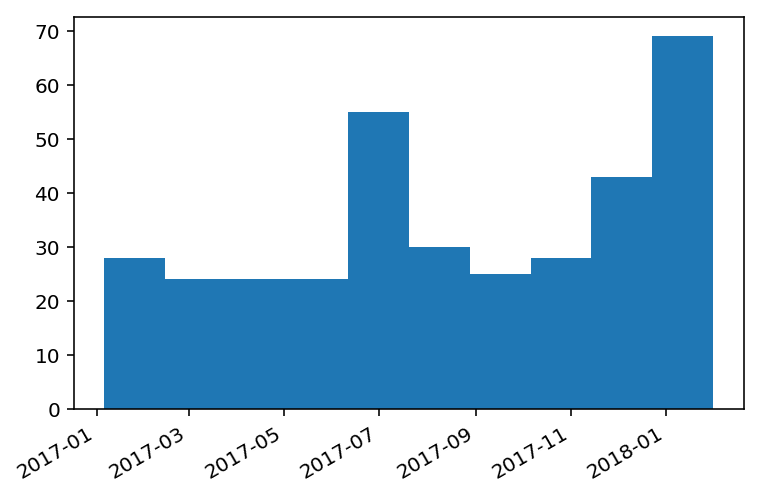

NEW
+------------------+------------------+
|min(purchase_date)|max(purchase_date)|
+------------------+------------------+
|        2018-02-01|        2018-03-30|
+------------------+------------------+



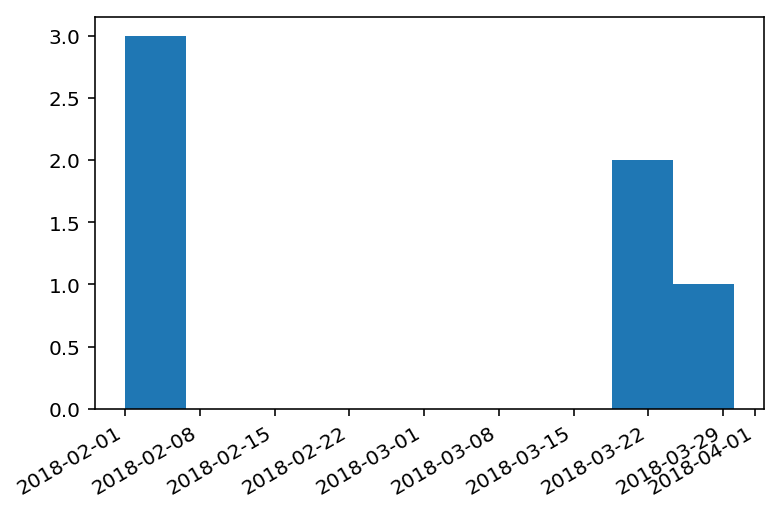

CPU times: user 425 ms, sys: 398 ms, total: 824 ms
Wall time: 20.7 s


In [13]:
%%time

for transactions_clazz, transactions_df in transactions_dfs.items():
    transactions_df = transactions_df.where(transactions_df.card_id == "C_ID_3d0044924f")
    transactions_df = transactions_df.withColumn("purchase_date", col("purchase_date").cast("date"))

    print(transactions_clazz.upper())
    
    transactions_df.select(
        min("purchase_date"),
        max("purchase_date"),
    ).show()
    
    purchase_dates = transactions_df.select("purchase_date").collect()
    purchase_dates = list(map(lambda x: x.purchase_date, purchase_dates))
    purchase_dates = pd.to_datetime(purchase_dates)

    fig = plt.figure()
    plt.hist(purchase_dates)
    fig.autofmt_xdate()
    plt.show()

In [61]:
spark.read.csv("data/raw/train.csv", header=True).where("target < -33.").show()

+------------------+---------------+---------+---------+---------+------------+
|first_active_month|        card_id|feature_1|feature_2|feature_3|      target|
+------------------+---------------+---------+---------+---------+------------+
|           2017-09|C_ID_8186f3fcc1|        3|        1|        1|-33.21928095|
|           2015-05|C_ID_b9379a30ea|        3|        3|        1|-33.21928095|
|           2015-10|C_ID_e9120f535c|        3|        3|        1|-33.21928095|
|           2017-03|C_ID_65715cb80d|        4|        2|        0|-33.21928095|
|           2017-01|C_ID_ae77d244b6|        2|        1|        0|-33.21928095|
|           2015-07|C_ID_c4262c902e|        5|        1|        1|-33.21928095|
|           2017-03|C_ID_6a2c823e5f|        2|        1|        0|-33.21928095|
|           2017-06|C_ID_98e1cb10b6|        2|        3|        0|-33.21928095|
|           2017-03|C_ID_eb8175721a|        4|        1|        0|-33.21928095|
|           2016-04|C_ID_a2580006bf|    

In [3]:
%%time

tmp_df = spark.read.csv("data/1-partitioned/*/transactions.csv", header=True)

tmp_df = tmp_df.where(tmp_df.card_id == "C_ID_962d44f420")
tmp_df = tmp_df.withColumn("authorized_flag", when(tmp_df.authorized_flag == 'Y', 1).otherwise(0))
tmp_df = tmp_df.withColumn("purchase_date", col("purchase_date").cast("timestamp"))

tmp_df = tmp_df.groupBy(
    year("purchase_date"),
    month("purchase_date"),
)

tmp_df = tmp_df.agg(
    count("authorized_flag"),
    mean("authorized_flag"),
)

tmp_df.sort(
    "year(purchase_date)",
    "month(purchase_date)",
).show()

+-------------------+--------------------+----------------------+--------------------+
|year(purchase_date)|month(purchase_date)|count(authorized_flag)|avg(authorized_flag)|
+-------------------+--------------------+----------------------+--------------------+
|               2017|                   6|                    13|  0.9230769230769231|
|               2017|                   7|                     7| 0.42857142857142855|
|               2017|                   8|                     6|  0.6666666666666666|
|               2017|                   9|                     8|               0.875|
|               2017|                  10|                     5|                 0.4|
|               2017|                  11|                     8|               0.875|
|               2017|                  12|                    22|  0.8636363636363636|
|               2018|                   1|                     2|                 1.0|
|               2018|                   2| 

In [4]:
tmp_df = spark.read.csv("data/1-partitioned/*/transactions.csv", header=True)

tmp_df.groupBy("card_id").count().select(min("count"), max("count")).show()

+----------+----------+
|min(count)|max(count)|
+----------+----------+
|         2|      5582|
+----------+----------+



In [5]:
tmp_df = spark.read.csv("data/1-partitioned/*/transactions.csv", header=True)
tmp_df = tmp_df.withColumn("purchase_date", col("purchase_date").cast("date"))

tmp_df.select(
    min("purchase_date"),
    max("purchase_date"),
).show()

+------------------+------------------+
|min(purchase_date)|max(purchase_date)|
+------------------+------------------+
|        2017-01-01|        2018-04-30|
+------------------+------------------+



In [10]:
tmp_df = spark.read.csv("data/1-partitioned/**/transactions.csv", header=True)

tmp_df = tmp_df.withColumn("purchase_amount", col("purchase_amount").cast("float"))

tmp_df.select(
    # as is
    min("purchase_amount"),
    max("purchase_amount"),
    
    # with log
    min(log(col("purchase_amount") + 1)),
    max(log(col("purchase_amount") + 1)),
).show()

+--------------------+--------------------+-------------------------------+-------------------------------+
|min(purchase_amount)|max(purchase_amount)|min(LOG((purchase_amount + 1)))|max(LOG((purchase_amount + 1)))|
+--------------------+--------------------+-------------------------------+-------------------------------+
|          -0.7469078|           6010604.0|             -1.374001313734442|             15.609035967002358|
+--------------------+--------------------+-------------------------------+-------------------------------+

